<a href="https://colab.research.google.com/github/ThiagoMartinsThome/TFM/blob/master/BLSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import pandas as pd
import math
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, QuantileTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error , mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import joblib
rcParams['figure.figsize'] = 16, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load and prepare the data

#### Load the data

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TFM/tradebot_tfm/data_20day_chg_target.zip', parse_dates=['date'])

# load data
data = df.copy()
data.drop('long_name', axis=1, inplace=True)
data.dropna(inplace=True, axis=0)
data.sort_values(by=['ticker', 'date'], ascending=True, inplace=True)
data.set_index('date', inplace=True)

print('Null values: ', data.isnull().sum().sum())

data.head()

Null values:  0


,ticker,open,high,low,close,volume,sp_open,sp_high,sp_low,sp_close,sp_volume,sp_percent_change,percent_change,relative_change,year,month,day,day_of_year,week_of_year,quarter,f_14_period_rsi,f_14_period_stoch_k,f_20_period_cci,up_move,down_move,plus,minus,f_14_period_adx,diplus,diminus,ao,mom,macd,signal_x,f_14_period_stochastic_rsi,f_14_williams_r,bull,bear,uo,f_8_period_vama,deltawma,f_16_period_hma,tenkan,kijun,f_9_period_smm,f_9_period_ssma,f_9_period_dema,f_9_period_tema,f_18_period_trima,f_20_period_trix,f_10_period_er,f_20_period_kama,f_26_period_zlema,f_9_period_wma,f_20_period_evwma,vwap,ppo,signal_y,histo,roc,f_5_period_sma,f_5_period_ema,f_10_period_sma,f_10_period_ema,f_20_period_sma,f_20_period_ema,f_30_period_sma,f_30_period_ema,f_50_period_sma,f_50_period_ema,f_100_period_sma,f_100_period_ema,f_200_period_sma,f_200_period_ema,short_result,sector,industry
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-11-11,AAPL,0.921914,0.959390,0.914418,0.940652,35607600.0,28.214053,28.289897,28.119247,28.138208,88900,-0.002688,0.020325,0.023013,1993.0,11.0,11.0,315.0,45.0,4.0,60.349555,59.374851,43.972860,3.747602e-02,-1.499032e-02,0.037476,0.000000e+00,36.022545,29.416429,13.493711,0.102574,0.011243,0.039989,0.044281,0.599610,-40.625149,0.039216,-0.005756,55.330429,0.945870,0.931399,0.937907,0.937112,0.862096,0.944400,0.907955,0.942416,0.926890,0.826442,0.539938,0.050848,0.926042,0.967849,0.935405,0.862179,1.191158,4.528958,5.123036,-0.594078,5.462147,0.928659,0.931656,0.940652,0.927735,0.912732,0.898806,0.842089,0.874856,0.806337,0.862869,0.866003,0.927067,1.220093,1.040218,-10.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-12,AAPL,0.944399,0.959390,0.914418,0.951894,35915600.0,28.195089,28.365738,28.176128,28.270933,108200,0.004717,0.011952,0.007235,1993.0,11.0,12.0,316.0,45.0,4.0,61.832195,68.749683,44.949612,-1.787082e-07,1.703312e-07,0.000000,1.703312e-07,36.100008,27.315254,12.529900,0.095344,0.029981,0.039336,0.043292,0.592462,-31.250317,0.034684,-0.010287,61.292067,0.941706,0.933083,0.933950,0.938361,0.871321,0.948147,0.912837,0.947884,0.936265,0.837211,0.554601,0.133332,0.926584,0.966667,0.937237,0.864885,1.190371,4.429322,4.984293,-0.554971,0.000000,0.927910,0.938402,0.943650,0.932128,0.917979,0.903862,0.851084,0.879827,0.809935,0.866361,0.863433,0.927568,1.216010,1.039203,-7.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-15,AAPL,0.944400,0.981876,0.944400,0.959390,39275600.0,28.327813,28.327813,28.176124,28.251968,243300,-0.000671,0.007875,0.008546,1993.0,11.0,15.0,319.0,46.0,4.0,62.830174,69.231257,72.776436,2.248626e-02,-2.998154e-02,0.022486,0.000000e+00,36.561073,28.873022,11.634907,0.093602,0.014991,0.038973,0.042428,0.587757,-30.768743,0.052215,0.014739,55.698258,0.943250,0.939213,0.935329,0.938778,0.882131,0.948147,0.918009,0.954242,0.945976,0.848118,0.566746,0.071429,0.926963,0.968349,0.940402,0.868122,1.189586,4.362565,4.859948,-0.497383,3.225861,0.935405,0.945398,0.945149,0.937085,0.923413,0.909151,0.860328,0.884960,0.813683,0.870011,0.860565,0.928209,1.211705,1.038288,-8.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-16,AAPL,0.959390,1.026847,0.951895,1.019352,75770800.0,28.308858,28.403664,28.195092,28.384703,492600,0.004698,0.062500,0.057801,1993.0,11.0,16.0,320.0,46.0,4.0,69.663353,94.444463,131.443152,4.497108e-02,-7.494871e-03,0.044971,0.000000e+00,37.634356,33.828155,10.803841,0.100932,0.037476,0.043028,0.042548,0.583771,-5.555537,0.084373,0.009421,59.569664,0.957204,0.964699,0.947400,0.942109,0.893230,0.951894,0.929270,0.980103,0.981341,0.858864,0.582450,0.161291,0.929377,0.979344,0.956059,0.877925,1.188333,4.766695,4.841297,-0.074602,10.569099,0.958640,0.970049,0.948896,0.952042,0.932782,0.919646,0.870821,0.893630,0.818330,0.875869,0.858819,0.930045,1.207848,1.038071,-12.0,Information Technology,"Technology Hardware, Storage & Peripherals"
1993-11-17,AAPL,1.019352,1.

#### Define features and targets

In [6]:
# Define features and target
X, y = data.drop('short_result', axis=1), data['short_result']
train = data[data['year'] <= 2018]
val = data[(data['year'] > 2018) & (data['year'] <= 2019)]
test = data[data['year'] > 2019]

X_train, y_train = train.drop('short_result', axis=1), train['short_result']
X_test, y_test = test.drop('short_result', axis=1), test['short_result']
X_val, y_val = val.drop('short_result', axis=1), val['short_result']


#### Build a Pipeline

Min value:  -1.45
Max value:  1.67
(266487, 60)


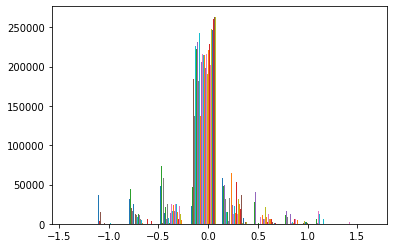

In [7]:
#Pipeline
#Column transformation
# determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Column preparation
transformer = [
               ('scaler', MinMaxScaler(feature_range=(0,1)), numerical_cols),
               ('onehot', OneHotEncoder(sparse=False), categorical_cols),
               #('scaler', StandardScaler(), numerical_cols),
               ]
col_transform = ColumnTransformer(transformers=transformer)

pipeline_x = Pipeline(steps=[('prep', col_transform),
                             ('pca', PCA(n_components=60, random_state=1))
                             ])
pipeline_y =  Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0,1)))])

pipeline_x.fit(X)
pipeline_y.fit(y.values.reshape(-1, 1))

joblib.dump(pipeline_x, 'pipeline_x.pkl', compress=1)
joblib.dump(pipeline_y, 'pipeline_y.pkl', compress=1)

with open('pipeline_x.pkl',  'rb') as f_x:
    pipeline_x_loaded = joblib.load(f_x)

with open('pipeline_y.pkl',  'rb') as f_y:
    pipeline_y_loaded = joblib.load(f_y)

X_train_scaled, y_train_scaled = pipeline_x_loaded.transform(X_train), pipeline_y_loaded.transform(y_train.values.reshape((-1,1)))
X_val_scaled, y_val_scaled = pipeline_x_loaded.transform(X_val), pipeline_y_loaded.transform(y_val.values.reshape((-1,1)))

X_train_scaled.astype('float32')
y_train_scaled.astype('float32')

X_val_scaled.astype('float32')
y_val_scaled.astype('float32')

print('Min value: ', round(X_train_scaled.min(),2))
print('Max value: ', round(X_train_scaled.max(),2))
plt.hist(X_train_scaled);
print(X_train_scaled.shape)

Min value:  0.0
Max value:  1.0


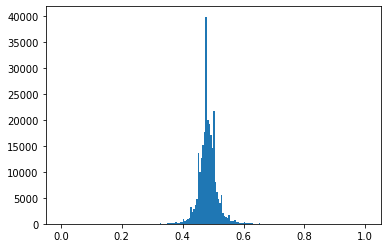

In [8]:
print('Min value: ', round(y_train_scaled.min(),2))
print('Max value: ', round(y_train_scaled.max(),2))
plt.hist(y_train_scaled, bins=200);

#### Split the data into sequences to be used for the model

In [9]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 20
# Concat features and target
train_dataset = np.hstack((X_train_scaled, y_train_scaled))
val_dataset = np.hstack((X_val_scaled, y_val_scaled))
# convert into input/output
X_train_split, y_train_split = split_sequences(train_dataset, n_steps)
y_train_split = np.reshape(y_train_split, (-1, 1))

X_val_split, y_val_split = split_sequences(val_dataset, n_steps)
y_val_split = np.reshape(y_val_split, (-1, 1))
# the dataset knows the number of features, e.g. 2
n_features = X_train_split.shape[2]

#X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_split, y_train_split, test_size=0.3, shuffle=False)

print(X_train_split.shape, y_train_split.shape)
print(X_val_split.shape, y_val_split.shape)

(266468, 20, 60) (266468, 1)
(12329, 20, 60) (12329, 1)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(500, 
                             activation='relu',
                             #kernel_regularizer='l2',
                             dropout=0.2, 
                             #go_backwards=True,
                             return_sequences=True),
                        input_shape=(n_steps, n_features)))
model.add(BatchNormalization())
model.add(LSTM(units=250,
               activation='relu',
               #kernel_regularizer='l2',
               dropout=0.2,
               go_backwards=True,
               return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(units=100,
               activation='relu',
               #kernel_regularizer='l2',
               dropout=0.2,
               go_backwards=True,
               ))
model.add(BatchNormalization())
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mse', metrics=['mae'])

#Model path
checkpoint_path = 'Blstm_model.h5'


# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=False,
                              verbose=1, save_best_only=True,
                              monitor='loss')
# Create a callback that prevents overfitting
early_stopping = EarlyStopping(monitor='loss', mode='auto', verbose=2, patience=10)

# Create a call back to improve the learning of the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-5, mode='min')

# fit model

history = model.fit(X_train_split,y_train_split,epochs=200,batch_size=1024,
                    callbacks=[cp_callback, early_stopping, reduce_lr],
                    validation_data=(X_val_split, y_val_split), shuffle=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Epoch 1/200
261/261 [==============================] - ETA: 0s - loss: 0.0606 - mae: 0.1031
Epoch 00001: loss improved from inf to 0.06062, saving model to Blstm_model.h5
261/261 [==============================] - 39s 149ms/step - loss: 0.0606 - mae: 0.1031 - val_loss: 4.5061e-04 - val_mae: 0.0164
Epoch 2/200
261/261 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0317
Epoch 00002: loss improved from 0.06062 to 0.00222, saving model to Blstm_model.h5
261/261 [==============================] - 38s 146ms/step - loss: 0.0022 - mae: 0.0317 - val_loss: 5.8874e-04 - val_mae: 0.0182
Epoch 3/200
261/261 [==============================] - ETA: 0s - loss: 0.0016 - mae: 0.0274
Epoch 00003: loss improved from 0.00222 to 0.00156, saving model to Blstm_model.h5
261/261 [==============================] - 38s 146ms/step - loss: 0.0016 - mae: 0.0274 - val_loss: 5.7389e-04 - val_mae: 0.0182
Epoch 4/200
261/261 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0267
Epo

## Test the model

In [11]:
X_test_scaled = pipeline_x_loaded.transform(X_test)
y_test_scaled = pipeline_y_loaded.transform(y_test.values.reshape((-1,1)))

X_test_scaled.astype('float32')
y_test_scaled.astype('float32')

# Concat features and target
test_dataset = np.hstack((X_test_scaled, y_test_scaled))
# convert into input/output
X_test_split, y_test_split = split_sequences(test_dataset, n_steps)
y_test_split = np.reshape(y_test_split, (-1, 1))
# the dataset knows the number of features, e.g. 2
n_features = X_test_split.shape[2]

# Load model
model = load_model('Blstm_model.h5')
yhat = model.predict(X_test_split)
#predicted = yhat#.reshape((-1, 1)) # For TimeDistributed
predicted = pipeline_y_loaded.inverse_transform(yhat)

evaluation = model.evaluate(X_test_split, y_test_split)
print('Model evaluation: ', evaluation)

256/256 [==============================] - 2s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0383
Model evaluation:  [0.0029281231109052896, 0.03831842541694641]


In [12]:
df_predicted = pd.DataFrame()
df_predicted['short_result'] = y_test.iloc[n_steps -1:]
df_predicted['predictions'] = predicted
#df_predicted.reset_index(inplace=True)
print(df_predicted.tail(20))

            short_result  predictions
date                                 
2020-08-03          -8.0    -0.294702
2020-08-04         -10.0    -0.589437
2020-08-05         -11.0    -1.243210
2020-08-06          -9.0    -1.783214
2020-08-07          -9.0    -2.358909
2020-08-10         -11.0    -2.066383
2020-08-11         -13.0    -2.112396
2020-08-12         -12.0    -2.094042
2020-08-13          -9.0    -2.592225
2020-08-14         -10.0    -2.723417
2020-08-17          -8.0    -2.648029
2020-08-18          -7.0    -2.320113
2020-08-19          -7.0    -1.946249
2020-08-20          -5.0    -1.519284
2020-08-21          -4.0    -0.738990
2020-08-24          -6.0     0.383697
2020-08-25          -2.0     1.140873
2020-08-26           1.0     1.979461
2020-08-27           2.0     2.930186
2020-08-28           0.0     3.701167


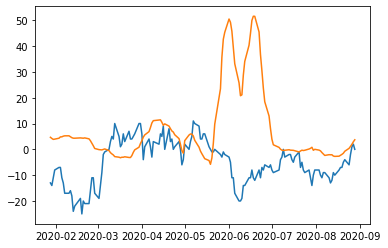

In [20]:
plt.plot(df_predicted.iloc[-150:]);
#plt.plot(df_predicted.date.loc[-1000:], df_predicted.short_result.loc[-1000:])
#plt.plot(df_predicted.date.loc[-1000:], df_predicted.predictions.loc[-1000:])

In [14]:
df_predicted.describe().T

,count,mean,std,min,25%,50%,75%,max
short_result,8163.0,0.396055,7.473768,-40.000000,-4.000000,0.000000,5.000000,38.000000
predictions,8163.0,1.614717,10.332435,-68.312073,-2.309145,1.266007,5.147686,87.945381


In [15]:
# Metrics
mse = round(mean_squared_error(y_test.iloc[n_steps -1:],predicted), 2)
rmse = math.sqrt(mean_squared_error(y_test.iloc[n_steps -1:],predicted))
mae = round(mean_absolute_error(y_test.iloc[n_steps -1:],predicted), 2)
r2 = round(r2_score(y_test.iloc[n_steps -1:],predicted), 2) 
print('mse: ', mse)
print('rmse: ', rmse)
print('mae: ', mae)
print('r2: ', r2)

mse:  168.66
rmse:  12.986914126384958
mae:  9.2
r2:  -2.02
